# Importing phase

## Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import mlflow
import mlflow.sklearn
import numpy as np
import shap

## Importing the dataset

In [2]:
data_train = pd.read_csv("application_train.csv")

# Preparing the data

## Removing missing values

Removing rows with at least one missing value

In [3]:
data_train = data_train.dropna(axis = 0)

## Transforming to dummies

Transforming non-numerical variables to dummies

In [4]:
data_train = pd.get_dummies(data_train, columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

## Separating the target

We have to separate the 'TARGET' variable from the dataset, as it will be predicted

In [5]:
Y = data_train['TARGET']

Dropping the 'TARGET' variable from the original set

In [6]:
X = data_train.drop(columns = ['TARGET'])

## Splitting the data

We use scikit-learn to split the data into train and test sets

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Creating models

Creating function to choose the model

In [8]:
def choosemodel():
    choice = int(input("What model do you want to use?\n Write '1' for Random Forest,\n Write '2' for Gradient Boosting,\n Write '3' for XGBoost"))
    return choice

In [9]:
def eval_metrics(Y_test, targets):
        msqe = np.sqrt(mean_squared_error(Y_test, targets))
        mae = mean_absolute_error(Y_test, targets)
        r2 = r2_score(Y_test, targets)
        # Calculating accuracy using scikit-learn
        accuracy = metrics.accuracy_score(Y_test, targets)
        return msqe, mae, r2, accuracy

In [10]:
choice = 0

Asking the user what model he wants to use

In [11]:
while ((choice != 1) and (choice != 2) and (choice != 3)):
    choice = choosemodel()
    if ((choice != 1) and (choice != 2) and (choice != 3)):
        print("You have to write 1, 2, or 3! Try again")

What model do you want to use?
 Write '1' for Random Forest,
 Write '2' for Gradient Boosting,
 Write '3' for XGBoost 3


Asking to user how many estimators he wants

In [12]:
estimators = int(input("How many estimators do you want?"))

How many estimators do you want? 10


Creating the chosen model

In [14]:
# Launching mlflow and select the chosen model
with mlflow.start_run():
    if (choice == 1):
        model = RandomForestClassifier(n_estimators = estimators)
    elif (choice == 2):
        model = GradientBoostingClassifier(n_estimators = estimators)
    elif (choice == 3):
        model = xgb.XGBClassifier(n_estimators = estimators, use_label_encoder = False)
    # Fitting the model
    model.fit(X_train, Y_train)
    # Predicting targets
    targets = model.predict(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    np.abs(shap_values.sum(1) + explainer.expected_value - targets).max()
    # Calculating metrics
    (msqe, mae, r2, accuracy) = eval_metrics(Y_test, targets)
    # Logging parameters to MLflow
    mlflow.log_param("model", choice)
    mlflow.log_param("estimators", estimators)
    # Logging metrics to MLflow
    mlflow.log_metric("msqe", msqe)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("accuracy", accuracy)
    # Logging model to MLflow
    mlflow.sklearn.log_model(model, "model")

[00:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


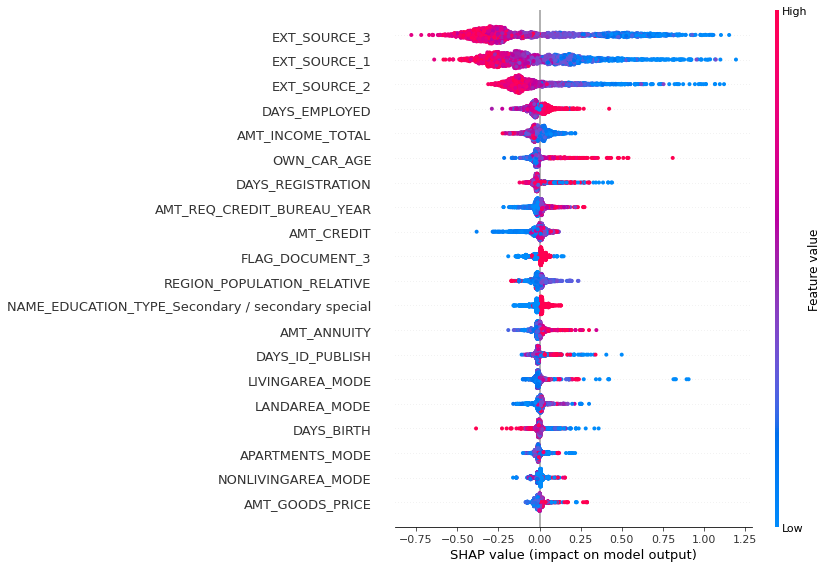

In [24]:
shap.summary_plot(shap_values, X_test)